In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ml_metrics import rmse
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import altair as alt
import seaborn as sns

# Helper Functions

In [2]:
def rand_msng(feat_msng, imp_val, df_obj, frac_msng=0.3, rand_state=99):

    try:
        df_msng = df_obj.sample(frac=frac_msng, random_state=rand_state)
        df_not_msng = df_obj[~df_obj.isin(df_msng)].dropna()
        df_msng[feat_msng] = np.nan
        #concatenate the not missing with the missing dataframe
        df_new = pd.concat([df_msng, df_not_msng])
        df_new[feat_msng] = df_new[feat_msng].fillna(imp_val)
        df_new = df_new.sort_index()
    
    except:
        df_new = None
    
    return df_new

def msng_at_rand(feat_crit, feat_msng, imp_val, df_obj, use_crit=1, rand_state=99):

    try:
        df_msng = df_obj.query("{0} < {1}".format(feat_crit,use_crit))
        df_not_msng = df_obj[~df_obj.isin(df_msng)].dropna()
        df_msng[feat_msng] = np.nan
        #concatenate the not missing with the missing dataframe
        df_new = pd.concat([df_msng, df_not_msng])
        df_new[feat_msng] = df_new[feat_msng].fillna(imp_val)
        df_new = df_new.sort_index()
        
    except:
        df_new = None
    
    return df_new

def msng_not_at_rand(feat_msng, imp_val, df_obj, frac_msng=0.25, rand_state=99):

    try:
        myIndex = int(((1-frac_msng)*len(df_obj)))
        df_msng = df_obj.iloc[myIndex:]
        df_not_msng = df_obj[~df_obj.isin(df_msng)].dropna()
        df_msng[feat_msng] = np.nan
        #concatenate the not missing with the missing dataframe
        df_new = pd.concat([df_msng, df_not_msng])
        df_new[feat_msng] = df_new[feat_msng].fillna(imp_val)
        df_new = df_new.sort_index()
    
    except:
        df_new = None
    
    return df_new

def add_to_results_df(scenario, df_full_res, frac, reg_obj, y_tst, y_predict):

        #get coefficients and feature names into dataframe
        df_coeff = pd.DataFrame()
        myList = reg_obj.coef_.tolist()
        for i in myList:
            data_dict = []
            var_index = reg_obj.coef_.tolist().index(i)
            tmp_dict = {data.feature_names[var_index]:i}
            data_dict.append(tmp_dict)
            df_tmp = pd.DataFrame(data_dict)
            df_coeff[data.feature_names[var_index]] = df_tmp[data.feature_names[var_index]].values
        
        #calculate model metrics and add to dataframe
        data_dict = [] #reuse existing data dictionary
        mae = mean_absolute_error(y_tst,y_predict)
        mse = mean_squared_error(y_tst,y_predict)
        rmse_val = rmse(y_tst,y_predict)
        r2 = r2_score(y_tst,y_predict)
        mae_diff = mae-orig_mae
        mse_diff = mse-orig_mse
        rsme_diff = rmse_val-orig_rmse_val
        r2_diff = r2-orig_r2
        tmp_dict = {'Scenario': '{0} {1}'.format(scenario,frac),'mae': mae, 'mse': mse, 'rmse_val':rmse_val, 'r2':r2, 'mae_diff':mae_diff, 'mse_diff':rsme_diff, 'r2_diff':r2_diff}
        data_dict.append(tmp_dict)
        df_metrics = pd.DataFrame(data_dict)
        #add coefficients to metrics
        df_metrics = df_metrics.join(df_coeff)
        df_metrics = pd.concat([df_full_res, df_metrics])
    
        return df_metrics

# Prepare Dataset

In [3]:
# Load in the dataset
data = datasets.fetch_california_housing()
print(data.data.shape)

(20640, 8)


In [4]:
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [5]:
df = pd.DataFrame(data.data)
df.columns = data.feature_names
df['MedHouseVal'] = data.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [6]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [7]:
#save original index of full data for later use
full_index = df.index.values.astype(int)
# Create training and testing sets 
train_set = df.sample(frac=0.7, random_state=100)
test_set = df[~df.isin(train_set)].dropna()
# Get the training and testing row indices 
train_index = train_set.index.values.astype(int)
test_index = test_set.index.values.astype(int)
print(train_set.shape[0])
print(test_set.shape[0])

14448
6192


In [8]:
# Converting the training and testing datasets back to matrix-formats
X_train = train_set.iloc[:, 0:8].values # returns the data; excluding the target
Y_train = train_set.iloc[:, -1].values # returns the target-only
X_test = test_set.iloc[:, 0:8].values # ""
Y_test = test_set.iloc[:, -1].values # ""

# Establish Baseline Model and Metrics

In [9]:
#get baseline regression model and associated metrics
reg = LinearRegression(normalize=True).fit(X_train, Y_train)
print(reg.score(X_train, Y_train))
print(reg.coef_)
print(reg.intercept_)
print(reg.get_params())

0.6160214522398206
[ 4.59063361e-01  9.72601795e-03 -1.37408894e-01  8.20058010e-01
 -5.20832695e-06 -3.38987100e-03 -4.12859546e-01 -4.28244613e-01]
-36.614838649470215
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': True, 'positive': False}


In [10]:
Y_pred = reg.predict(X_test)

orig_mae = mean_absolute_error(Y_test,Y_pred)
orig_mse = mean_squared_error(Y_test,Y_pred)
orig_rmse_val = rmse(Y_test,Y_pred)
orig_r2 = r2_score(Y_test,Y_pred)

In [11]:
#get the baseline model metrics and add to results dataframe
#get coefficients and feature names into dataframe
df_coeff = pd.DataFrame()
myList = reg.coef_.tolist()
for i in myList:
    data_dict = []
    var_index = reg.coef_.tolist().index(i)
    tmp_dict = {data.feature_names[var_index]:i}
    data_dict.append(tmp_dict)
    df_tmp = pd.DataFrame(data_dict)
    df_coeff[data.feature_names[var_index]] = df_tmp[data.feature_names[var_index]].values

#calculate model metrics and add to dataframe
data_dict = [] #reuse existing data dictionary
orig_mae = mean_absolute_error(Y_test,Y_pred)
orig_mse = mean_squared_error(Y_test,Y_pred)
orig_rmse_val = rmse(Y_test,Y_pred)
orig_r2 = r2_score(Y_test,Y_pred)
#add metrics to dictionary and into dataframe
tmp_dict = {'Scenario': 'Baseline','mae': orig_mae, 'mse': orig_mse, 'rmse_val':orig_rmse_val, 'r2':orig_r2, 'mae_diff':0, 'mse_diff':0, 'r2_diff':0}
data_dict.append(tmp_dict)
df_overall = pd.DataFrame(data_dict)
#add coefficients to metrics
df_overall = df_overall.join(df_coeff)
df_overall

,Scenario,mae,mse,rmse_val,r2,mae_diff,mse_diff,r2_diff,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,Baseline,0.53676,0.556336,0.74588,0.58016,0,0,0,0.459063,0.009726,-0.137409,0.820058,-0.000005,-0.00339,-0.41286,-0.428245


# Setting our Fields of Interest

In [12]:
msng_col = 'AveBedrms' #the column we will create missing values for and then fill in with imputation
crit_col = 'MedInc' #the column we will use as criteria for MAR
imputation_value = df[msng_col].iloc[train_index].median() #grab the median value for AveBedrms from training only

In [30]:
imputation_value

1.048373168421639

# MCAR Scenarios
Here we will run six scenarios where each scenario takes a percentage of the data (each incrementally larger), replaces the data in the column/feature specified with np.nan, then imputs it by using the median of the remaining

In [13]:
msng_pcnt = [.01, .05, .1, .2, .33, .5]
scen = 'MCAR'
for i in msng_pcnt:
    #get the data with imputed values
    df_new_msng = rand_msng(msng_col, imputation_value, df, i)
    #get into training and test
    train_set = df_new_msng.iloc[train_index]
    test_set = df_new_msng.iloc[test_index]
    X_train = train_set.iloc[:, 0:8].values # returns the data; excluding the target
    Y_train = train_set.iloc[:, -1].values # returns the target-only
    X_test = test_set.iloc[:, 0:8].values # ""
    Y_test = test_set.iloc[:, -1].values # ""
    #fit model
    reg = LinearRegression(normalize=True).fit(X_train, Y_train)
    #predict on test
    Y_pred = reg.predict(X_test)
    #get model metrics into overall results dataframe
    df_overall = add_to_results_df(scen, df_overall, i, reg, Y_test, Y_pred)

df_overall

,Scenario,mae,mse,rmse_val,r2,mae_diff,mse_diff,r2_diff,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,Baseline,0.536760,0.556336,0.745880,0.580160,0.000000,0.000000,0.000000,0.459063,0.009726,-0.137409,0.820058,-0.000005,-0.003390,-0.412860,-0.428245
0,MCAR 0.01,0.537307,0.556274,0.745838,0.580207,0.000546,-0.000042,0.000047,0.454422,0.009727,-0.128783,0.778883,-0.000005,-0.003374,-0.413770,-0.428876
0,MCAR 0.05,0.538831,0.555000,0.744983,0.581168,0.002070,-0.000896,0.001008,0.437932,0.009702,-0.098314,0.631925,-0.000006,-0.003308,-0.422831,-0.436398
0,MCAR 0.1,0.539948,0.554650,0.744748,0.581433,0.003188,-0.001132,0.001273,0.429892,0.009685,-0.083393,0.563440,-0.000006,-0.003277,-0.426258,-0.439242
0,MCAR 0.2,0.542243,0.557049,0.746357,0.579622,0.005483,0.000477,-0.000538,0.417438,0.009670,-0.060341,0.451626,-0.000006,-0.003230,-0.431645,-0.443396
0,MCAR 0.33,0.543259,0.556312,0.745864,0.580178,0.006499,-0.000016,0.000018,0.409140,0.009713,-0.044839,0.374337,-0.000006,-0.003204,-0.434371,-0.445394
0,MCAR 0.5,0.545718,0.561678,0.749452,0.576129,0.008958,0.003572,-0.004031,0.390850,0.009795,-0.009862,0.221452,-0.000005,-0.003133,-0.446140,-0.455352


# MAR

In [14]:
#take a column and create missing at random
#find a condition whereby if variable z meets a condition, variable x is randomly missing

the_criteria = [1.92,2.37,2.75]
scen = 'MAR'

for i in the_criteria:
    #get the data with imputed values
    #here, we are applying the criteria to MedInc where MedInc < the_criteria
    df_new_msng = msng_at_rand(crit_col,msng_col, imputation_value, df, i)
    #get into training and test
    train_set = df_new_msng.iloc[train_index]
    test_set = df_new_msng.iloc[test_index]
    X_train = train_set.iloc[:, 0:8].values # returns the data; excluding the target
    Y_train = train_set.iloc[:, -1].values # returns the target-only
    X_test = test_set.iloc[:, 0:8].values # ""
    Y_test = test_set.iloc[:, -1].values # ""
    #fit model
    reg = LinearRegression(normalize=True).fit(X_train, Y_train)
    #predict on test
    Y_pred = reg.predict(X_test)
    #get model metrics into overall results dataframe
    df_overall = add_to_results_df(scen, df_overall, i, reg, Y_test, Y_pred)

df_overall

C:\Users\blgai\anaconda3\envs\qtw\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\blgai\anaconda3\envs\qtw\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\blgai\anaconda3\envs\qtw\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

,Scenario,mae,mse,rmse_val,r2,mae_diff,mse_diff,r2_diff,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,Baseline,0.536760,0.556336,0.745880,0.580160,0.000000,0.000000,0.000000,0.459063,0.009726,-0.137409,0.820058,-0.000005,-0.003390,-0.412860,-0.428245
0,MCAR 0.01,0.537307,0.556274,0.745838,0.580207,0.000546,-0.000042,0.000047,0.454422,0.009727,-0.128783,0.778883,-0.000005,-0.003374,-0.413770,-0.428876
0,MCAR 0.05,0.538831,0.555000,0.744983,0.581168,0.002070,-0.000896,0.001008,0.437932,0.009702,-0.098314,0.631925,-0.000006,-0.003308,-0.422831,-0.436398
0,MCAR 0.1,0.539948,0.554650,0.744748,0.581433,0.003188,-0.001132,0.001273,0.429892,0.009685,-0.083393,0.563440,-0.000006,-0.003277,-0.426258,-0.439242
0,MCAR 0.2,0.542243,0.557049,0.746357,0.579622,0.005483,0.000477,-0.000538,0.417438,0.009670,-0.060341,0.451626,-0.000006,-0.003230,-0.431645,-0.443396
0,MCAR 0.33,0.543259,0.556312,0.745864,0.580178,0.006499,-0.000016,0.000018,0.409140,0.009713,-0.044839,0.374337,-0.000006,-0.003204,-0.434371,-0.445394
0,MCAR 0.5,0.545718,0.561678,0.749452,0.576129,0.008958,0.003572,-0.004031,0.390850,0.009795,-0.009862,0.221452,-0.000005,-0.003133,-0.446140,-0.455352
0,MAR 1.92,0.543546,0.595235,0.771515,0.550805,0.006786,0.025635,-0.029355,0.420831,0.009875,-0.069969,0.529785,-0.000006,-0.003248,-0.428782,-0.440173
0,MAR 2.37,0.544503,0.579056,0.760957,0.563015,0.007742,0.015078,-0.017145,0.408079,0.009854,-0.046754,0.414348,-0.000006,-0.003199,-0.434754,-0.445459
0,MAR 2.75,0.544942,0.571830,0.756194,0.568468,0.008181,0.010315,-0.011692,0.397581,0.009925,-0.026716,0.368457,-0.000006,-0.003165,-0.440929,-0.451109


# MNAR

In [15]:
scen = 'MNAR'
#get the data with imputed values
df_new_msng = msng_not_at_rand(msng_col, imputation_value, df, 0.25)
#get into training and test
train_set = df_new_msng.iloc[train_index]
test_set = df_new_msng.iloc[test_index]
X_train = train_set.iloc[:, 0:8].values # returns the data; excluding the target
Y_train = train_set.iloc[:, -1].values # returns the target-only
X_test = test_set.iloc[:, 0:8].values # ""
Y_test = test_set.iloc[:, -1].values # ""
#fit model
reg = LinearRegression(normalize=True).fit(X_train, Y_train)
#predict on test
Y_pred = reg.predict(X_test)
#get model metrics into overall results dataframe
df_overall = add_to_results_df(scen, df_overall, i, reg, Y_test, Y_pred)

df_overall

C:\Users\blgai\anaconda3\envs\qtw\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Scenario,mae,mse,rmse_val,r2,mae_diff,mse_diff,r2_diff,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,Baseline,0.536760,0.556336,0.745880,0.580160,0.000000,0.000000,0.000000,0.459063,0.009726,-0.137409,0.820058,-0.000005,-0.003390,-0.412860,-0.428245
0,MCAR 0.01,0.537307,0.556274,0.745838,0.580207,0.000546,-0.000042,0.000047,0.454422,0.009727,-0.128783,0.778883,-0.000005,-0.003374,-0.413770,-0.428876
0,MCAR 0.05,0.538831,0.555000,0.744983,0.581168,0.002070,-0.000896,0.001008,0.437932,0.009702,-0.098314,0.631925,-0.000006,-0.003308,-0.422831,-0.436398
0,MCAR 0.1,0.539948,0.554650,0.744748,0.581433,0.003188,-0.001132,0.001273,0.429892,0.009685,-0.083393,0.563440,-0.000006,-0.003277,-0.426258,-0.439242
0,MCAR 0.2,0.542243,0.557049,0.746357,0.579622,0.005483,0.000477,-0.000538,0.417438,0.009670,-0.060341,0.451626,-0.000006,-0.003230,-0.431645,-0.443396
0,MCAR 0.33,0.543259,0.556312,0.745864,0.580178,0.006499,-0.000016,0.000018,0.409140,0.009713,-0.044839,0.374337,-0.000006,-0.003204,-0.434371,-0.445394
0,MCAR 0.5,0.545718,0.561678,0.749452,0.576129,0.008958,0.003572,-0.004031,0.390850,0.009795,-0.009862,0.221452,-0.000005,-0.003133,-0.446140,-0.455352
0,MAR 1.92,0.543546,0.595235,0.771515,0.550805,0.006786,0.025635,-0.029355,0.420831,0.009875,-0.069969,0.529785,-0.000006,-0.003248,-0.428782,-0.440173
0,MAR 2.37,0.544503,0.579056,0.760957,0.563015,0.007742,0.015078,-0.017145,0.408079,0.009854,-0.046754,0.414348,-0.000006,-0.003199,-0.434754,-0.445459
0,MAR 2.75,0.544942,0.571830,0.756194,0.568468,0.008181,0.010315,-0.011692,0.397581,0.009925,-0.026716,0.368457,-0.000006,-0.003165,-0.440929,-0.451109


In [16]:
df_overall = df_overall.reset_index()

<AxesSubplot:>

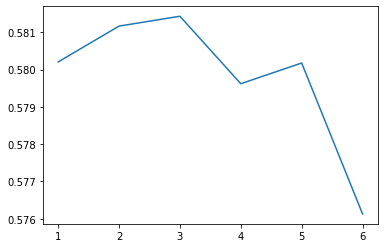

In [17]:
df_overall[df_overall['Scenario'].str.contains("MCAR")]['r2'].plot()

<AxesSubplot:>

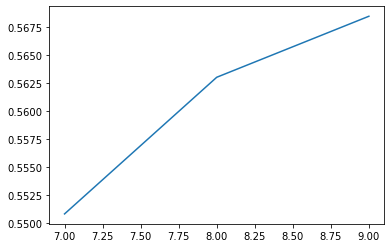

In [18]:
df_overall[df_overall['Scenario'].str.contains("MAR")]['r2'].plot()

In [48]:
search = ['Baseline','MAR']
df_overall[df_overall['Scenario'].str.contains('|'.join(search))][['Scenario','mae','mse','r2','MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']]

,Scenario,mae,mse,r2,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,Baseline,0.536760,0.556336,0.580160,0.459063,0.009726,-0.137409,0.820058,-0.000005,-0.003390,-0.412860,-0.428245
7,MAR 1.92,0.543546,0.595235,0.550805,0.420831,0.009875,-0.069969,0.529785,-0.000006,-0.003248,-0.428782,-0.440173
8,MAR 2.37,0.544503,0.579056,0.563015,0.408079,0.009854,-0.046754,0.414348,-0.000006,-0.003199,-0.434754,-0.445459
9,MAR 2.75,0.544942,0.571830,0.568468,0.397581,0.009925,-0.026716,0.368457,-0.000006,-0.003165,-0.440929,-0.451109


# Missing at Random (MAR) Scenario Analysis 

In [35]:
source = df_overall[df_overall['Scenario'].str.contains("MAR") | df_overall['Scenario'].str.contains("Baseline")]
alt.Chart(source).mark_line().encode(
    alt.Y('r2:Q', scale=alt.Scale(zero=False)),
    x='Scenario'
).properties(title='Change in r2 by MAR Scenario', width=300, height=200)

alt.Chart(...)

In [36]:
source = df_overall[df_overall['Scenario'].str.contains("MAR") | df_overall['Scenario'].str.contains("Baseline")]
alt.Chart(source).mark_line().encode(
    alt.Y('AveBedrms:Q', scale=alt.Scale(zero=False)),
    x='Scenario'
).properties(title='Change in AveBedrms Coefficient by MAR Scenario', width=300, height=200)

alt.Chart(...)

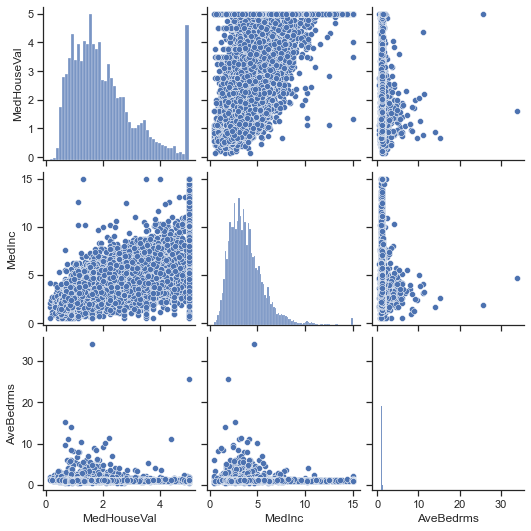

In [22]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df, vars=["MedHouseVal","MedInc","AveBedrms"])

Text(0.5, 1.0, 'Original Data Correlation')

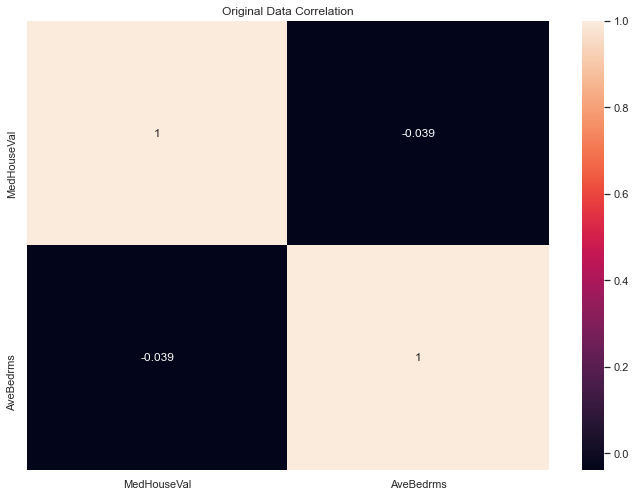

In [49]:
keepCols = ['MedHouseVal','AveBedrms']
df_prt = df[keepCols]
g = sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.heatmap(df_prt.corr(), annot = True, fmt='.2g')
plt.title("Original Data Correlation")

Text(0.5, 1.08, '10% of Data Imputed')

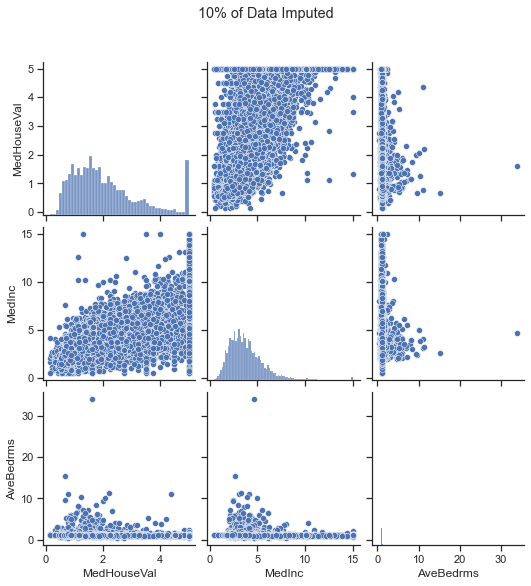

In [24]:
myCrit = 1.92
df_MAR = pd.read_csv('C:/Users/blgai/OneDrive/Documents/School/SMU/Courses/Spring 2021/Quantifying The World/Case Study 10/data/{}MAR.csv'.format(myCrit))
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df_MAR, vars=["MedHouseVal","MedInc","AveBedrms"])
g.fig.suptitle("10% of Data Imputed", y=1.08)

Text(0.5, 1.0, '10% Imputed Data Correlation')

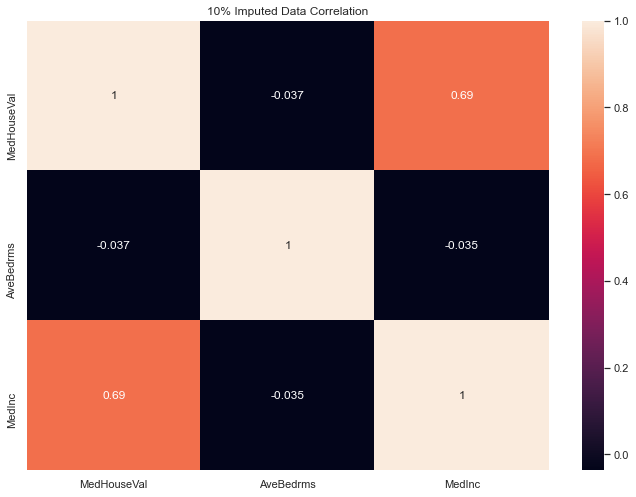

In [55]:
keepCols = ['MedHouseVal','AveBedrms', 'MedInc']
#the_criteria = [1.92,2.37,2.75]
myCrit = 1.92 #10% imputed data
df_MAR = pd.read_csv('C:/Users/blgai/OneDrive/Documents/School/SMU/Courses/Spring 2021/Quantifying The World/Case Study 10/data/{}MAR.csv'.format(myCrit))
df_MAR = df_MAR[keepCols]
g = sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.heatmap(df_MAR.corr(), annot = True, fmt='.2g')
plt.title("10% Imputed Data Correlation")

Text(0.5, 1.08, '20% of Data Imputed')

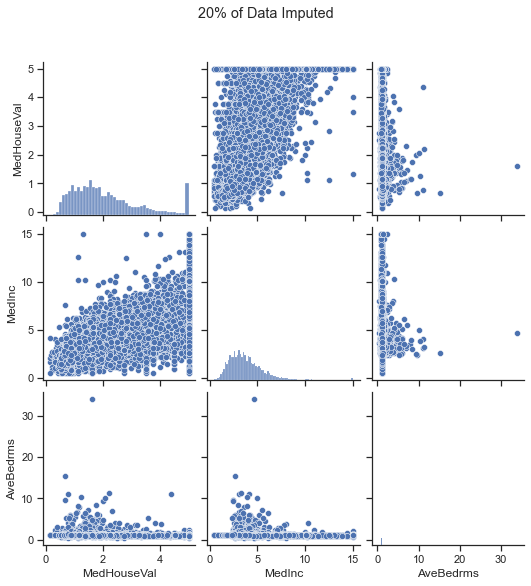

In [26]:
#the_criteria = [1.92,2.37,2.75]
myCrit = 2.37
df_MAR = pd.read_csv('C:/Users/blgai/OneDrive/Documents/School/SMU/Courses/Spring 2021/Quantifying The World/Case Study 10/data/{}MAR.csv'.format(myCrit))
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df_MAR, vars=["MedHouseVal","MedInc","AveBedrms"])
g.fig.suptitle("20% of Data Imputed", y=1.08)

Text(0.5, 1.0, '20% Imputed Data Correlation')

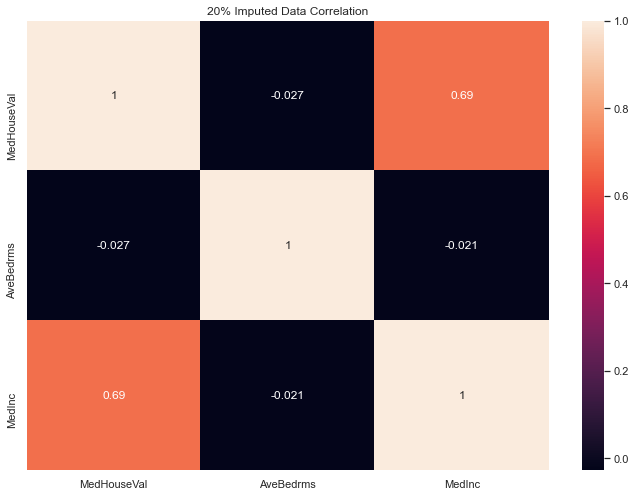

In [54]:
keepCols = ['MedHouseVal','AveBedrms', 'MedInc']
#the_criteria = [1.92,2.37,2.75]
myCrit = 2.37 #20% imputed data
df_MAR = pd.read_csv('C:/Users/blgai/OneDrive/Documents/School/SMU/Courses/Spring 2021/Quantifying The World/Case Study 10/data/{}MAR.csv'.format(myCrit))
df_MAR = df_MAR[keepCols]
g = sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.heatmap(df_MAR.corr(), annot = True, fmt='.2g')
plt.title("20% Imputed Data Correlation")

Text(0.5, 1.08, '30% of Data Imputed')

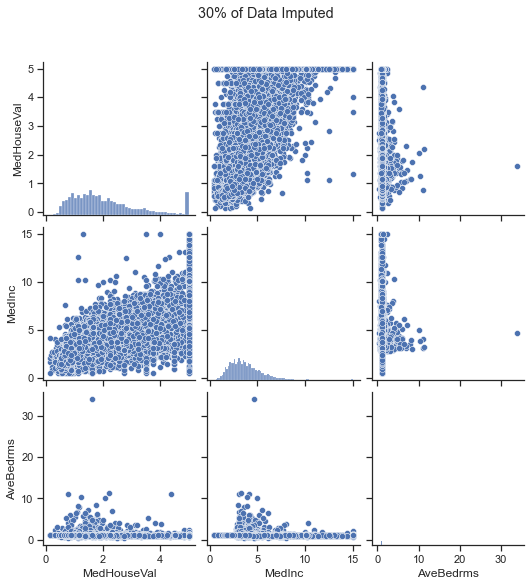

In [28]:
#the_criteria = [1.92,2.37,2.75]
myCrit = 2.75 #30% imputed data
df_MAR = pd.read_csv('C:/Users/blgai/OneDrive/Documents/School/SMU/Courses/Spring 2021/Quantifying The World/Case Study 10/data/{}MAR.csv'.format(myCrit))
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df_MAR, vars=["MedHouseVal","MedInc","AveBedrms"])
g.fig.suptitle("30% of Data Imputed", y=1.08)

Text(0.5, 1.0, '30% Imputed Data Correlation')

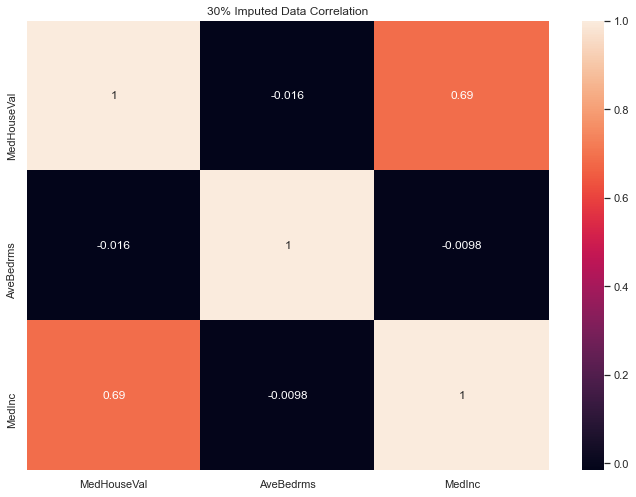

In [53]:
keepCols = ['MedHouseVal','AveBedrms', 'MedInc']
#the_criteria = [1.92,2.37,2.75]
myCrit = 2.75
df_MAR = pd.read_csv('C:/Users/blgai/OneDrive/Documents/School/SMU/Courses/Spring 2021/Quantifying The World/Case Study 10/data/{}MAR.csv'.format(myCrit))
df_MAR = df_MAR[keepCols]
g = sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.heatmap(df_MAR.corr(), annot = True, fmt='.2g')
plt.title("30% Imputed Data Correlation")